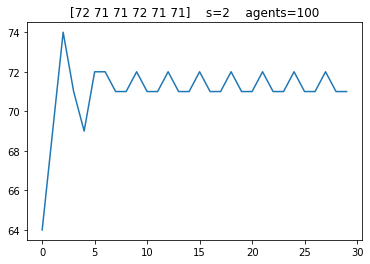

In [80]:
import numpy as np
from matplotlib import pyplot as plt


def make_unbiased_strategies(rng, strategies, memory):
    # weights should sum to 1
    # essentially, we are partitioning the [0,1] interval
    # and taking the size of each sub-interval
    # TODO: add negative weights?
    w = rng.uniform(-1, 1, size=(strategies, memory-1))
    w.sort(axis=1)
    offsets = np.hstack([w[:, :], np.ones(shape=(strategies,1))])
    return offsets - np.hstack([np.zeros(shape=(strategies,1)), w[:, :]])


def make_uniform_strategies(rng, strategies, memory):
    return rng.uniform(-1,1, size=(strategies, memory))


def minimize_squared_error(rng,predictions,observations,threshold,strategies):
        # calculate the absolute error of predictions
        # here, we discard the rightmost prediction as
        # this is the prediction for the future.
        # if we knew the correct answer for that,
        # we wouldn't need to predict it!
        errs = ((predictions[:, :-1] - observations)**2).sum(axis=1)

        return np.argmin(errs)

    
class EFBPSim:
    def __init__(
        self,
        agents = 100, # number of agents
        threshold = 60, # threshold for attendance
        strategies = 10, # number of strategies
        # number of weeks back in predictor function
        # AND number of weeks back to look when selecting a predictor
        memory = 8,
        # number of rounds to run the simulation
        n_iter = 500,
        # current options are "unbiased", "uniform"
        distribution="unbiased",
        # alternately, caller may pass a new strategy function
        strategy_func=None,
        # function for selecting the best strategy
        best_strat_func=minimize_squared_error,
        # starting history
        start=None,
        # random seed for numpy
        seed=23
    ):
        
        rng = np.random.default_rng(seed)

        # each row is a strategy
        if not strategy_func:
            if distribution=="unbiased":
                strategy_func =  make_unbiased_strategies
            elif distribution=="uniform":
                strategy_func = make_uniform_strategies

        strats = [
            strategy_func(rng, strategies, memory) for _ in range(agents)
        ]

        if start is None:
            start = rng.uniform(agents, size=(memory*2))

        # weekly attendance count
        # the first 2*memory weeks are randomly generated
        # to seed the strategies
        hist = np.hstack([start, np.zeros(n_iter)]).astype(int)

        # index of week
        # we need some starting history to begin making selections
        t = memory * 2

        # Record the index of the optimal strategy 
        # on each iteration.
        # each row corresponds to an agent
        # each column corresponds to a week
        best_strats = np.zeros((agents, len(hist)))

        # record each agent's prediction on each iteration
        pred_history = np.zeros((agents, len(hist)))

        while t < memory * 2 + n_iter:

            # construct time windows for evaluating strategies

            # The columns begin at
            # t - m - 1 
            # t - m
            # ...
            # t - 1
            # as you go down the column you are looking back
            # to that week's history.
            # so the column beginning at *t - m - 1*
            # generates the prediction for week *t - m*
            # and the rightmost column generates a
            # prediction for next week.
            windows = np.vstack([
                hist[t-memory-i-1: t-i]
                for i in range(memory)
            ])

            for agent in range(agents):
                strat = strats[agent]
                # each row is a strategy
                # each column is predicted attendance
                # in increasing order.
                # the last column has the prediction for
                # next week
                predictions = strat.dot(windows)

                # these are the observations that we use to
                # to test our predictions.
                # note that the observation from column 0
                # is not used since its prediction would come
                # from a previous week's history.
                observations = windows[0, 1:]
                
                best_strat = best_strat_func(rng, predictions, observations, threshold, strategies)
                best_strats[agent, t] = best_strat

                pred = strat[best_strat].dot(windows[:,-1])
                pred_history[agent, t] = pred

            hist[t] = (pred_history[:, t] < threshold).sum()
            t += 1
            
        self.hist = hist[2*memory:]
        self.best_strats = best_strats[:, 2*memory:]
        self.pred_history = pred_history[:, 2*memory:]
        self.strats = strats
        
    def first_a(self):
        return [self.strats[i][int(s), 0] for i, s in enumerate(self.best_strats)]
    
    def jth_a(self, j):
        return [self.strats[i][int(s), j] for i, s in enumerate(self.best_strats)]
        
        
        

rng = np.random.default_rng(36)
h =  np.array([33, 95, 74, 85])
s = 2
agents = 100

sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

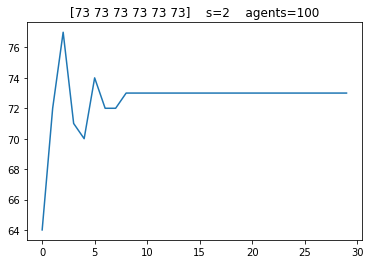

In [2]:
sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

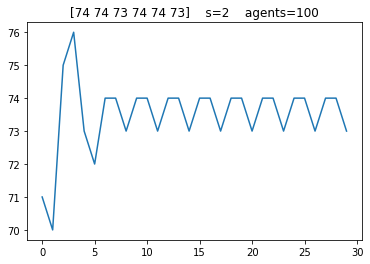

In [3]:
sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

A1 Mean: 0.25099385857282175
A2 Mean: 0.18507768561825888
A1 Std: 0.5052362705746213
A2 Std: 0.5317086738451494


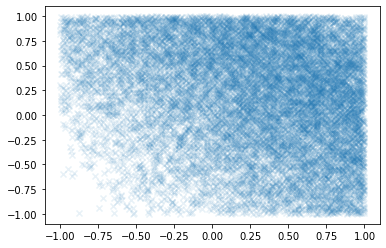

In [4]:
sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=1,
    agents=15000,
    distribution="uniform"
)

a1_sim = np.array(sim.jth_a(0))
a2_sim = np.array(sim.jth_a(1))

plt.scatter(a1_sim, a2_sim, marker="x", alpha = 0.1)

print(f"A1 Mean: {a1_sim.mean()}")
print(f"A2 Mean: {a2_sim.mean()}")

print(f"A1 Std: {a1_sim.std()}")
print(f"A2 Std: {a2_sim.std()}")

A1 Mean: 0.6151038701195564
A2 Mean: 0.41464835904400293
A1 Std: 0.20376343447620385
A2 Std: 0.2500786692777556


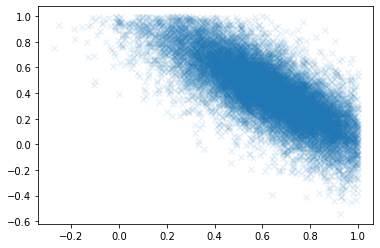

In [5]:
s=20
sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=1,
    agents=15000,
    distribution="uniform"
)

a1_sim = np.array(sim.jth_a(0))
a2_sim = np.array(sim.jth_a(1))

plt.scatter(a1_sim, a2_sim, marker="x", alpha = 0.1)

print(f"A1 Mean: {a1_sim.mean()}")
print(f"A2 Mean: {a2_sim.mean()}")

print(f"A1 Std: {a1_sim.std()}")
print(f"A2 Std: {a2_sim.std()}")

This looks like the same thing we had before!  Now let's switch up the best_strat_func...

In [6]:
memory=2
t=4

# The columns begin at
# t - m - 1 
# t - m
# ...
# t - 1
# as you go down the column you are looking back
# to that week's history.
# so the column beginning at *t - m - 1*
# generates the prediction for week *t - m*
# and the rightmost column generates a
# prediction for next week.
windows = np.vstack([
    h[t-memory-i-1: t-i]
    for i in range(memory)
])

agent = 0
strat = sim.strats[agent]
# each row is a strategy
# each column is predicted attendance
# in increasing order.
# the last column has the prediction for
# next week
predictions = strat.dot(windows)

# these are the observations that we use to
# to test our predictions.
# note that the observation from column 0
# is not used since its prediction would come
# from a previous week's history.
observations = windows[0, 1:]

In [7]:
windows

array([[95, 74, 85],
       [33, 95, 74]])

In [8]:
predictions

array([[  46.1835279 ,   55.5791579 ,   53.9044404 ],
       [ -96.05286607, -128.35612528, -120.30169045],
       [  52.46381805,   89.85198729,   78.38039031],
       [ -75.27273441,  -97.71314706,  -92.43078886],
       [  39.21725909,   26.48746354,   32.48293937],
       [ -26.06407807,  -41.20907137,  -36.73839669],
       [ -85.85981995,  -73.16307301,  -80.85426941],
       [ -45.04481116,  -50.46033149,  -50.16958298],
       [  19.77350535,   40.84611876,   34.02190371],
       [  39.72144562,   64.57719806,   57.1281633 ],
       [ -81.35773052,  -41.9949729 ,  -59.07299136],
       [  31.18039113,   72.9800497 ,   59.14910323],
       [  51.26188254,  -27.5872791 ,    2.53279334],
       [  46.1017534 ,    1.72412733,   19.30774648],
       [  41.14612981,   68.69627091,   60.33427555],
       [  95.00907508,  135.06999536,  124.19858978],
       [  49.30179851,   88.18602843,   76.06278967],
       [ -18.03542411,  -51.00202567,  -39.85380916],
       [ -64.7290972 ,  -50.

In [9]:
observations < 60

array([False, False])

In [10]:
predictions < 60

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True, False, False],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True, False,  True],
       [ True,  True,  True],
       [ True, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True, False, False],
       [False, False, False],
       [ True, False, False],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [11]:
performances = np.tile(observations < 60, (20, 1)) == (predictions[:, :-1] < 60)
performances

array([[False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True],
       [False,  True],
       [False, False],
       [False, False],
       [False, False]])

In [12]:
np.argmin(performances.sum(axis=1))

0

In [13]:
rng.uniform(0,0.1, size=20) + performances.sum(axis=1)

array([0.08938324, 0.0403386 , 1.06830046, 0.05110809, 0.05354266,
       0.08753545, 0.02460519, 0.01421473, 0.03286209, 1.04084949,
       0.0657251 , 1.0934419 , 0.02168267, 0.02796443, 1.01983421,
       2.04842524, 1.02692577, 0.07611999, 0.09199378, 0.0633071 ])

In [14]:
def pick_optimal_choices(rng,predictions,observations,threshold,strategies):
    # how often does each predictor match the desired ooutcome?
    performances = np.tile(observations < threshold, (strategies, 1)) == (predictions[:, :-1] < threshold)
    
    # add noise to randomize tie breaker
    scores = rng.uniform(0,0.1, size=strategies) + performances.sum(axis=1)
    return np.argmax(scores)

pick_optimal_choices(rng,predictions,observations,60,20)

15

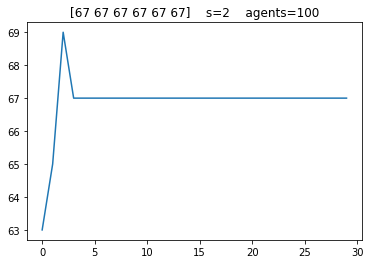

In [15]:
rng = np.random.default_rng(36)
h =  np.array([33, 95, 74, 85])
s = 2
agents = 100

sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

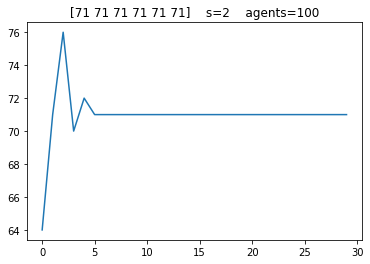

In [16]:
sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

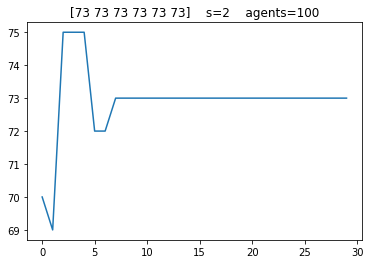

In [17]:
sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

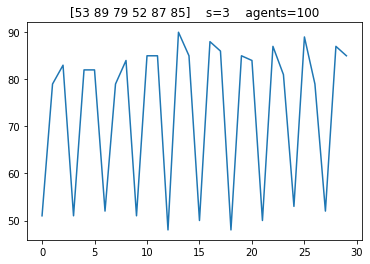

In [18]:
s = 3
agents = 100

sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

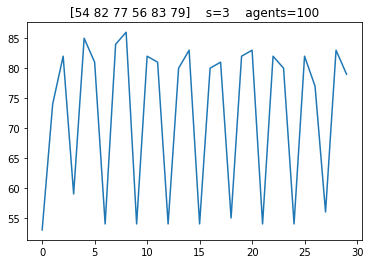

In [19]:
s = 3
agents = 100

sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

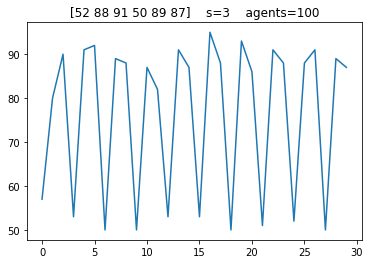

In [20]:
s = 3
agents = 100

sim = EFBPSim(
    memory=2, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [21]:
memory = 5

h = rng.choice(101, size=memory*2)
h

array([94, 40, 93, 68, 45, 51, 90, 54, 45, 88])

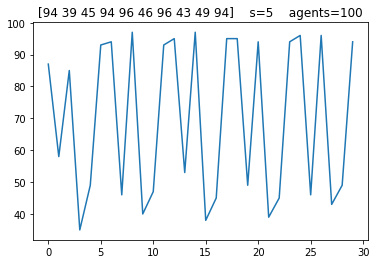

In [22]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-10:]}    s={s}    agents={agents}")

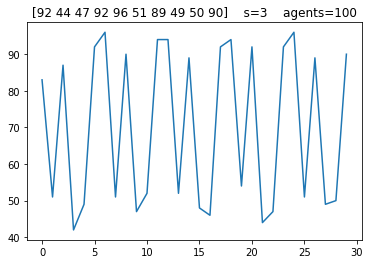

In [23]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-10:]}    s={s}    agents={agents}")

In [24]:
memory = 10

h = rng.choice(101, size=memory*2)
h

array([ 7, 14, 75, 33, 15, 41,  0, 66, 88, 94, 49, 21, 29, 28, 29, 20,  0,
       48, 54, 27])

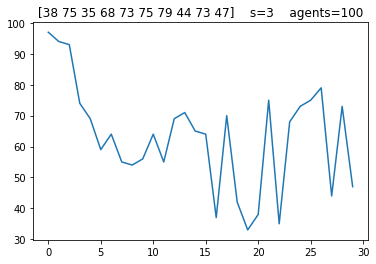

In [25]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-10:]}    s={s}    agents={agents}")

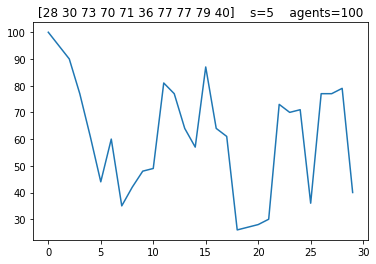

In [26]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-10:]}    s={s}    agents={agents}")

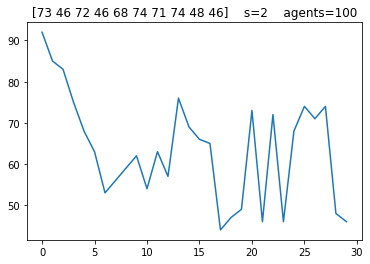

In [27]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=30,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-10:]}    s={s}    agents={agents}")

In [28]:
memory = 20

h = rng.choice(101, size=memory*2)
h

array([ 92,  71,  63,  58,   2,  47,  46,  95,  56,  60,  27,  40,  40,
        78,  42,  21,  16,  36,   8,  69,  48,   8,  80,  94,  28,  56,
        62,   4,   3, 100,  88,  16,  90,  56,  93,  62,  34,  24,  40,
        58])

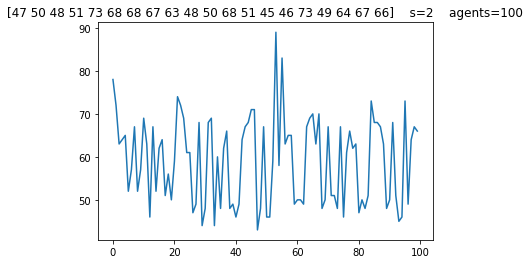

In [29]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-memory:]}    s={s}    agents={agents}")

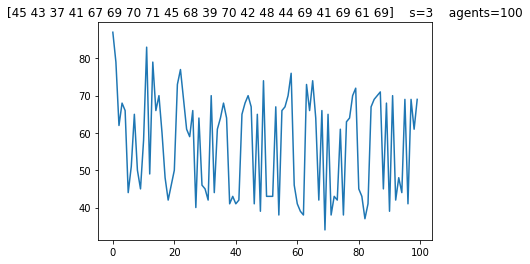

In [30]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-memory:]}    s={s}    agents={agents}")

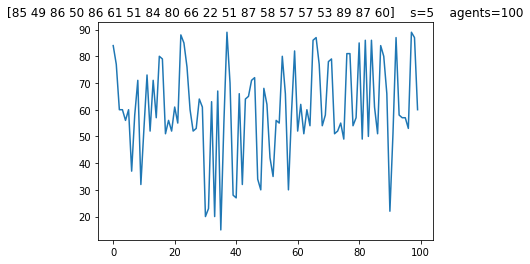

In [31]:
s = 5
sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-memory:]}    s={s}    agents={agents}")

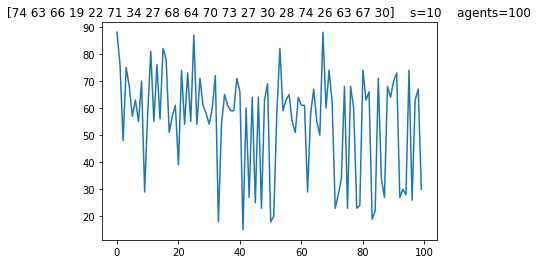

In [32]:
s = 10
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-memory:]}    s={s}    agents={agents}")

What if we have strategy distribution centered so it won't underestimate?

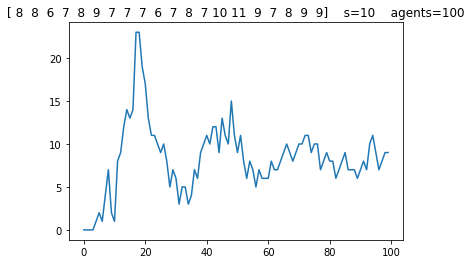

In [33]:
def make_centered_strategies(rng, strategies, memory):
    return rng.uniform(-1,3, size=(strategies, memory))


s = 10
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-memory:]}    s={s}    agents={agents}")

In [34]:
memory = 2

h = rng.choice(101, size=memory*2)
h

array([91, 57,  0, 93])

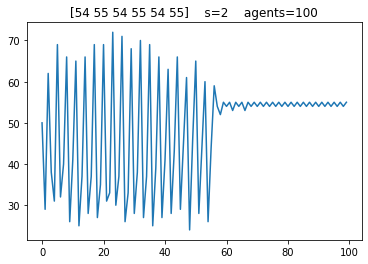

In [35]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

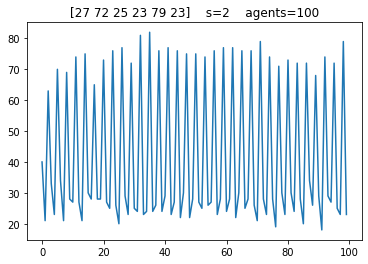

In [36]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

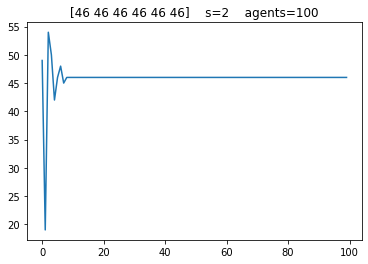

In [37]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

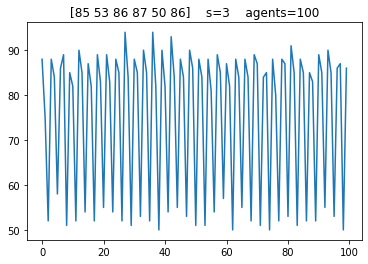

In [38]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    distribution="uniform",
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

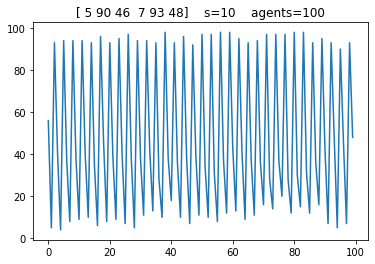

In [39]:
s = 10

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [40]:
memory = 5

h = rng.choice(101, size=memory*2)
h

array([44, 70, 72, 44, 32, 78, 39, 43, 49, 95])

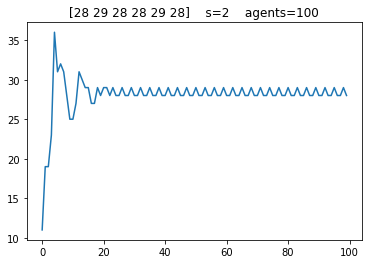

In [41]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

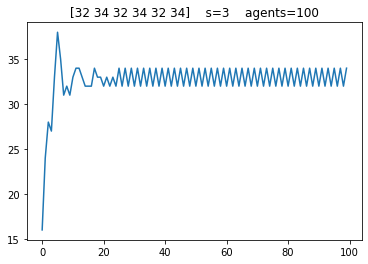

In [42]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

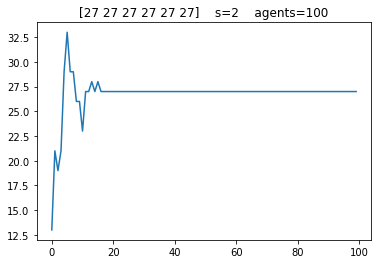

In [43]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

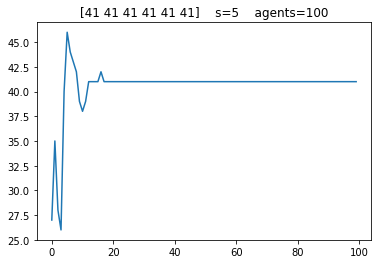

In [44]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

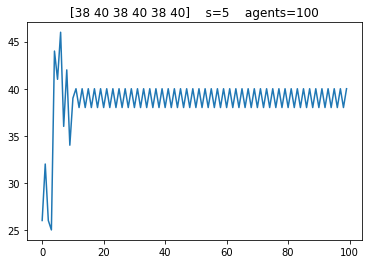

In [45]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

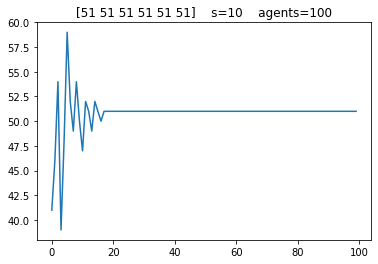

In [46]:
s = 10
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [47]:
memory = 5
agents = 5

h = rng.choice(agents+1, size=memory*2)
h

array([1, 3, 0, 1, 0, 3, 0, 1, 1, 4])

[3 0 1 1 4]
[[-3.05695403  7.03056209  0.60017768  8.04650567  0.30644527 10.02647442]
 [ 6.09353743 -0.67388303 10.08901241  0.79164652  6.31144861  2.24533073]
 [ 3.93634552 10.955658    4.10393071  7.59211856  2.61984577 13.20375846]
 [11.36810096  3.38868578  9.48834365 -0.31530379 10.23459542  5.76686406]
 [-1.18899907 -1.36669863  1.62428568 -1.06788295 -1.75090287 -1.068002  ]
 [ 9.45563966  2.97864719  7.26191681  1.04523764  7.93594271  4.40985874]
 [ 5.51966674  9.43128441  6.29638888  3.02084222  7.17051501 13.6017266 ]
 [ 7.13882635  1.15892701  5.33958807  3.94002948  6.16913652  1.81210778]
 [ 6.1982414  -0.34295577  6.93748858  3.90678785  7.38567839  1.6562877 ]
 [ 9.42062477 13.65913043  3.85199407  2.09733937  8.71667993 16.35182789]]
[[False False  True False False]
 [ True  True False  True  True]
 [ True False False False False]
 [ True False False  True  True]
 [False  True  True  True False]
 [ True  True False  True  True]
 [ True False False False  True]
 [ Tru

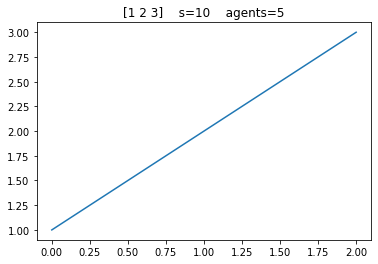

In [48]:
def pick_optimal_choices(rng,predictions,observations,threshold,strategies):
    # how often does each predictor match the desired ooutcome?
    performances = np.tile(observations < threshold, (strategies, 1)) == (predictions[:, :-1] < threshold)
    print(observations)
    print(predictions)
    print(performances)
    
    # add noise to randomize tie breaker
    scores = rng.uniform(0,0.1, size=strategies) + performances.sum(axis=1)
    print(performances.sum(axis=1))
    return np.argmax(scores)

s = 10
agents = 5
threshold=3

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=3,
    agents=agents,
    threshold=3,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [49]:
def make_centered_strategies(rng, strategies, memory):
    return rng.uniform(-1,1, size=(strategies, memory)) + 1/memory


def pick_optimal_choices(rng,predictions,observations,threshold,strategies):
    # how often does each predictor match the desired ooutcome?
    performances = np.tile(observations < threshold, (strategies, 1)) == (predictions[:, :-1] < threshold)
    
    # add noise to randomize tie breaker
    scores = rng.uniform(0,0.1, size=strategies) + performances.sum(axis=1)
    return np.argmax(scores)

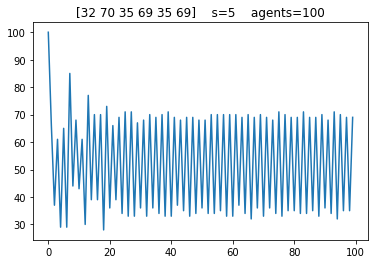

In [50]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

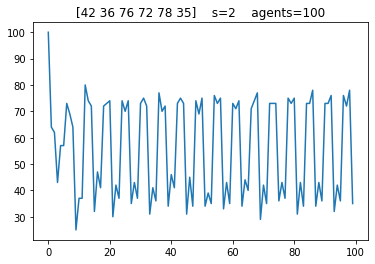

In [51]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [52]:
memory = 10

h = rng.choice(101, size=memory*2)
h

array([60, 72, 71, 93, 29, 68, 63, 90, 47, 52, 89, 18, 76, 42,  7, 13, 91,
        5, 67, 71])

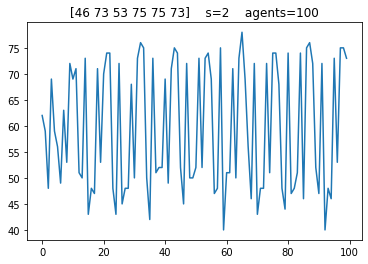

In [53]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

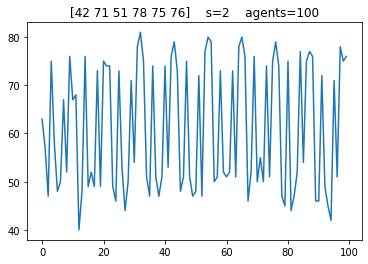

In [54]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

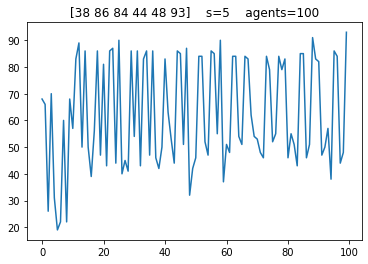

In [55]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [56]:
memory = 50

h = rng.choice(101, size=memory*2)
h

array([29, 96, 46, 12, 65,  0, 87, 44, 94, 17, 58, 94, 75, 93, 82,  7, 89,
       77, 50, 66, 33, 52, 90, 93, 19, 21, 42, 32, 97, 39, 23, 15, 18, 50,
       50, 36, 65, 43, 47, 65, 75, 13, 74, 38, 25, 90, 16, 67, 21, 43, 74,
       21, 36, 43, 32,  7, 17, 10,  5, 60, 27, 25, 46, 22, 31, 72, 99, 61,
        0, 52, 13, 70,  4, 22, 48, 31, 56, 96, 57,  0, 91, 85, 66, 81, 46,
       17, 46, 93, 15, 89, 87, 44, 32, 13, 59, 12,  1, 21, 38,  3])

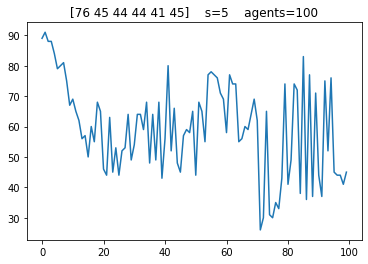

In [57]:
s = 5
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

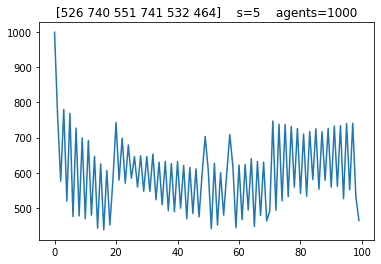

In [58]:
s = 5
agents = 1000

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    threshold=600,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [59]:
memory = 100

h = rng.choice(101, size=memory*2)

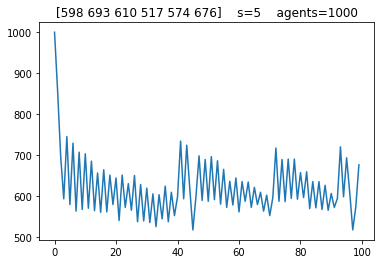

In [60]:
s = 5
agents = 1000

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    threshold=600,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

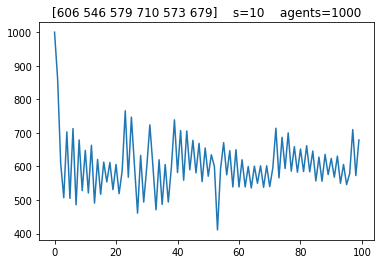

In [61]:
s = 10
agents = 1000

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    threshold=600,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

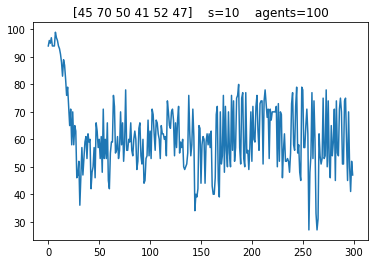

In [62]:
s = 10
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=300,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    threshold=60,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [63]:
def make_broader_centered_strategies(rng, strategies, memory):
    return rng.uniform(-10,10, size=(strategies, memory)) + 1/memory

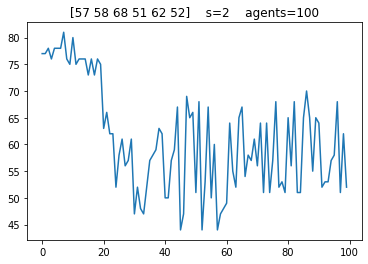

In [64]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_broader_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [65]:
sim.hist[-30:]

array([56, 64, 51, 64, 51, 57, 68, 52, 53, 51, 65, 56, 68, 51, 51, 65, 70,
       65, 55, 65, 64, 52, 53, 53, 57, 58, 68, 51, 62, 52])

In [66]:
memory = 10

h = rng.choice(11, size=memory*2)

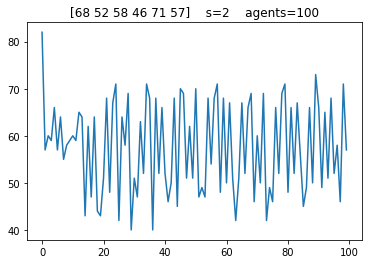

In [67]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_broader_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

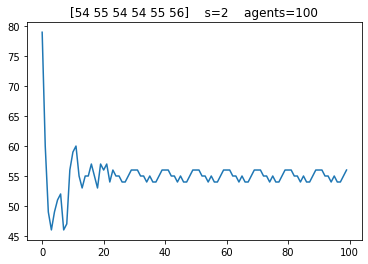

In [68]:
s = 2
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_broader_centered_strategies,
    # best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

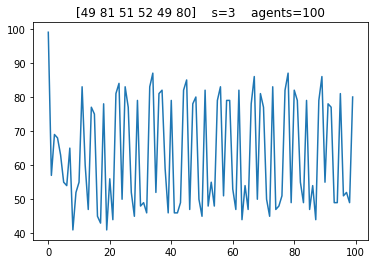

In [69]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_broader_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

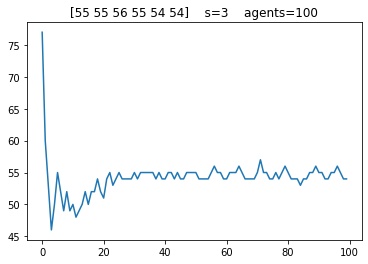

In [70]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_broader_centered_strategies,
    # best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

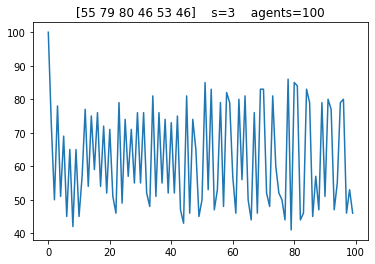

In [71]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=100,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

In [72]:
memory = 100

h = rng.choice(memory+1, size=memory*2)

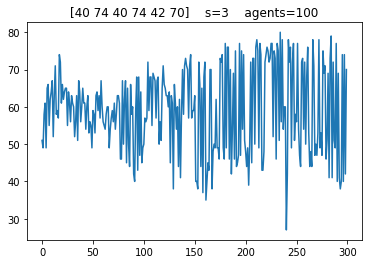

In [73]:
s = 3
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=300,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

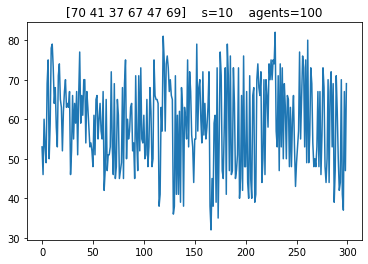

In [74]:
s = 10
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=300,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

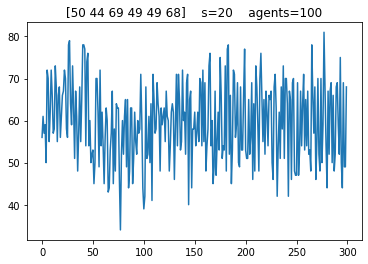

In [75]:
s = 20
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=300,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

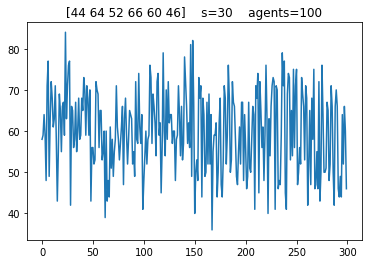

In [76]:
s = 30
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=300,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

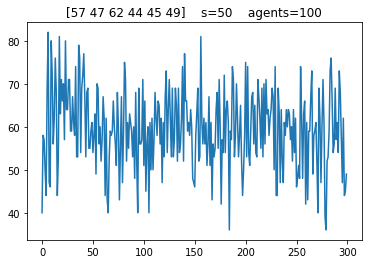

In [77]:
s = 50
agents = 100

sim = EFBPSim(
    memory=memory, 
    strategies=s,
    start=h, 
    n_iter=300,
    agents=agents,
    strategy_func=make_centered_strategies,
    best_strat_func=pick_optimal_choices,
    seed=rng.choice(10000)
)

plt.figure()
plt.plot(sim.hist)
_ = plt.title(f"{sim.hist[-6:]}    s={s}    agents={agents}")

Big questions:

Does using the optimal choice function always mean attendance will fluctuate around the threshold?


Can we predict where variance will be minimized in this regime?

In [78]:
exceptions = []

for _ in range(50):
    memory = rng.choice(100) + 2
    strategies = rng.choice(100) + 2
    # threshold cannot be 0 or 100 
    threshold = rng.choice(99) + 1

    h = rng.choice(agents+1, size=memory*2)
    n_iter = max(100, memory * 3)

    sim = EFBPSim(
        memory=memory, 
        strategies=strategies,
        threshold=threshold,
        start=h, 
        n_iter=n_iter,
        agents=agents,
        strategy_func=make_broader_centered_strategies,
        best_strat_func=pick_optimal_choices,
        seed=rng.choice(10000)
    )

    # does it cross the threshold within the memory window?
    under_t = (sim.hist[-memory:] < threshold).sum()

    if under_t == 0 or under_t == memory:
        exceptions.append({"s": strategies, "m": memory, "t": threshold})
        print(exceptions[-1])

{'s': 4, 'm': 17, 't': 4}
{'s': 2, 'm': 23, 't': 4}


Looks good!  Can we get a sense of when/where variance is lowest?

In [ ]:
threshold = 60

strategies, memory = np.meshgrid(np.arange(2, 103, 5), np.arange(2, 103, 5))

mins = np.zeros(strategies.shape)
maxs = np.zeros(strategies.shape)
stds = np.zeros(strategies.shape)

n = strategies.shape[0]

for i in range(n):
    for j in range(n):
        
        h = rng.choice(agents+1, size=memory[i,j]*2)
        n_iter = max(100, memory[i,j] * 3)

        sim = EFBPSim(
            memory=memory[i,j], 
            strategies=strategies[i,j],
            threshold=threshold,
            start=h, 
            n_iter=n_iter,
            agents=agents,
            strategy_func=make_broader_centered_strategies,
            best_strat_func=pick_optimal_choices,
            seed=rng.choice(100000)
        )

        end_window = max(memory[i,j] * 2, 50)

        # does it cross the threshold within the memory window?
        under_t = (sim.hist[-end_window:] < threshold).sum()
        if under_t == 0 or under_t == end_window:
            print(f"Does not cross threshold at ({i}, {j})")

        mins[i,j] = (sim.hist[-end_window:]).min()
        maxs[i,j] = (sim.hist[-end_window:]).max()
        stds[i,j] = (sim.hist[-end_window:]).std()

<ipython-input-104-8ec5372cca92>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')


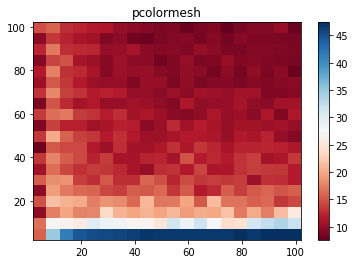

In [104]:
fig, ax = plt.subplots()

c = ax.pcolormesh(strategies, memory, stds, cmap='RdBu')
ax.set_title('pcolormesh')
# set the limits of the plot to the limits of the data
ax.axis([2, 102, 2, 102])
fig.colorbar(c, ax=ax)

plt.show()

i is memory, j is strategy

In [108]:
memory[0,1]

2

In [109]:
strategies[0,1]

7

We seem to have that lower variance with longer memory and either two strategies or many strategies.  Why is this?

Shorter memory means some slices of strategy space may be more strongly preferred over others.  I think we need to understand the theory better here.  But let's try with a different threshold while we're here.

2

7